In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy
import scipy.io as sio
import scipy.io.wavfile
import copy


---
# High-pass filters
---


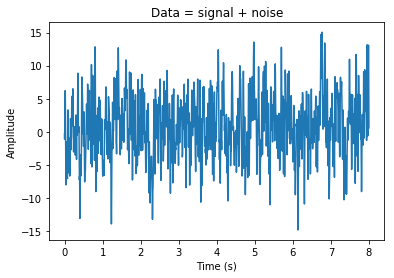

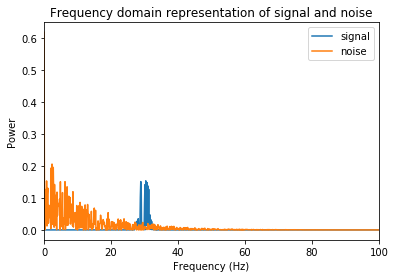

In [2]:
# generate 1/f noise
N   = 8000
fs  = 1000
as1 = np.random.rand(N) * np.exp(-np.arange(0,N)/200)
fc  = as1 * np.exp(1j*2*np.pi*np.random.rand(len(as1)))
noise = np.real(scipy.fftpack.ifft(fc)) * N



### create frequency-domain Gaussian
hz = np.linspace(0,fs,N)
s  = 4*(2*np.pi-1)/(4*np.pi); # normalized width
x  = hz-30                    # shifted frequencies
fg = np.exp(-.5*(x/s)**2)     # gaussian

fc = np.random.rand(N) * np.exp(1j*2*np.pi*np.random.rand(N))
fc = fc * fg

# generate signal from Fourier coefficients, and add noise
signal1 = np.real( scipy.fftpack.ifft(fc) )*N
data = signal1 + noise
time = np.arange(0,N)/fs


### plot the data
plt.plot(time,data)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Data = signal + noise')
plt.show()

plt.plot(hz,np.abs(scipy.fftpack.fft(signal1)/N)**2,label='signal')
plt.plot(hz,np.abs(scipy.fftpack.fft(noise)/N)**2,label='noise')
plt.legend()
plt.xlim([0,100])
plt.title('Frequency domain representation of signal and noise')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.show()

/Users/elliottevers/DocumentsTurbulent/virtual_environments/python_3_jupyter/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/elliottevers/DocumentsTurbulent/virtual_environments/python_3_jupyter/lib/python3.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


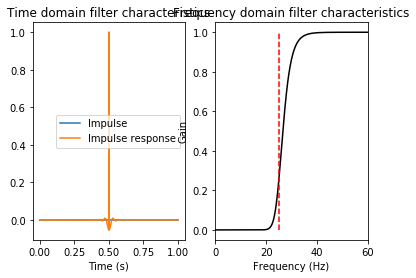

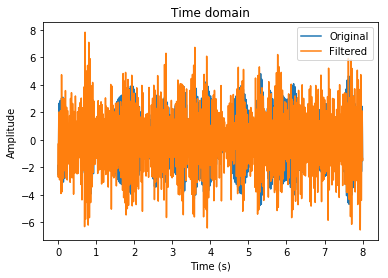

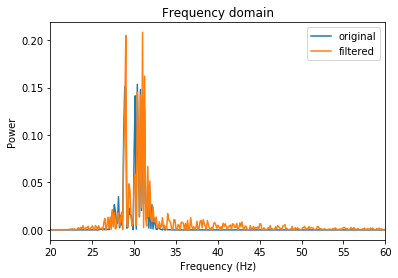

In [3]:
## now for high-pass filter

# specify filter cutoff (in Hz)
filtcut = 25

# generate filter coefficients (Butterworth)
filtb,filta = signal.butter(7,filtcut/(fs/2),btype='high')

# test impulse response function (IRF)
impulse  = np.zeros(1001)
impulse[501] = 1
fimpulse = signal.filtfilt(filtb,filta,impulse)
imptime  = np.arange(0,len(impulse))/fs


# plot impulse and IRF
plt.subplot(121)
plt.plot(imptime,impulse,label='Impulse')
plt.plot(imptime,fimpulse/np.max(fimpulse),label='Impulse response')
plt.xlabel('Time (s)')
plt.legend()
plt.title('Time domain filter characteristics')


# plot spectrum of IRF
plt.subplot(122)
hz = np.linspace(0,fs/2,3000)
imppow = np.abs(scipy.fftpack.fft(fimpulse,2*len(hz)))**2
plt.plot(hz,imppow[:len(hz)],'k')
plt.plot([filtcut,filtcut],[0,1],'r--')
plt.xlim([0,60])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.title('Frequency domain filter characteristics')
plt.show()


# now filter the data and compare against the original
fdata = signal.filtfilt(filtb,filta,data)
plt.plot(time,signal1,label='Original')
plt.plot(time,fdata,label='Filtered')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Time domain')
plt.show()


### power spectra of original and filtered signal
signalX = np.abs(scipy.fftpack.fft(signal1)/N)**2
fdataX  = np.abs(scipy.fftpack.fft(fdata)/N)**2
hz = np.linspace(0,fs,N)

plt.plot(hz,signalX[:len(hz)],label='original')
plt.plot(hz,fdataX[:len(hz)],label='filtered')
plt.xlim([20,60])
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Frequency domain')
plt.show()


---
# Narrowband filters
---


/Users/elliottevers/DocumentsTurbulent/virtual_environments/python_3_jupyter/lib/python3.7/site-packages/scipy/linalg/basic.py:1321: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  x, resids, rank, s = lstsq(a, b, cond=cond, check_finite=False)


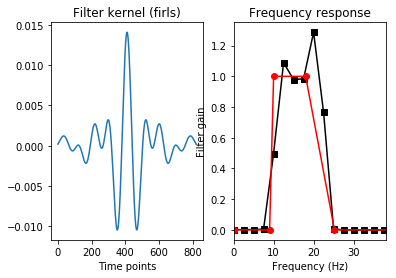

In [4]:
# define filter parameters
lower_bnd = 10 # Hz
upper_bnd = 18 # Hz

lower_trans = .1
upper_trans = .4

samprate  = 2048 # Hz
filtorder = 4*np.round(samprate/lower_bnd)+1

filter_shape = [ 0,0,1,1,0,0 ]
filter_freqs = [ 0, lower_bnd*(1-lower_trans), lower_bnd, upper_bnd, \
                upper_bnd+upper_bnd*upper_trans,  samprate/2 ]

filterkern = signal.firls(filtorder,filter_freqs,filter_shape,fs=samprate)
hz = np.linspace(0,samprate/2,int(np.floor(len(filterkern)/2)+1))
filterpow = np.abs(scipy.fftpack.fft(filterkern))**2


# let's see it
plt.subplot(121)
plt.plot(filterkern)
plt.xlabel('Time points')
plt.title('Filter kernel (firls)')


# plot amplitude spectrum of the filter kernel
plt.subplot(122)
plt.plot(hz,filterpow[:len(hz)],'ks-')
plt.plot(filter_freqs,filter_shape,'ro-')

# make the plot look nicer
plt.xlim([0,upper_bnd+20])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Filter gain')
plt.title('Frequency response')
plt.show()


/Users/elliottevers/DocumentsTurbulent/virtual_environments/python_3_jupyter/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/elliottevers/DocumentsTurbulent/virtual_environments/python_3_jupyter/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/elliottevers/DocumentsTurbulent/virtual_environments/python_3_jupyter/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: Fu

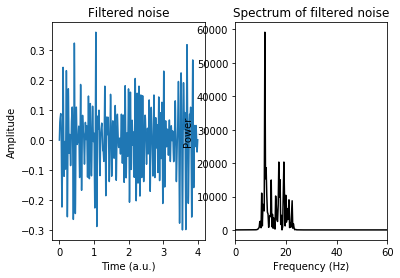

In [5]:
## now apply to random noise data

filtnoise = signal.filtfilt(filterkern,1,np.random.randn(samprate*4))
timevec = np.arange(0,len(filtnoise))/samprate

# plot time series
plt.subplot(121)
plt.plot(timevec,filtnoise)
plt.xlabel('Time (a.u.)')
plt.ylabel('Amplitude')
plt.title('Filtered noise')


# plot power spectrum
noisepower = np.abs(scipy.fftpack.fft(filtnoise))**2
plt.subplot(122)
plt.plot(np.linspace(0,samprate,len(noisepower)),noisepower,'k')
plt.xlim([0,60])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Spectrum of filtered noise')
plt.show()


---
# Two-stage wide-band filter
---


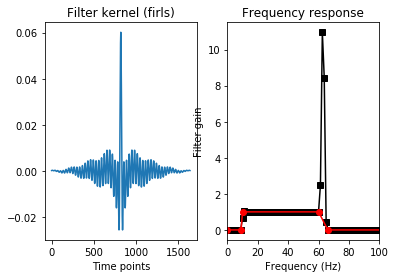

In [6]:
# define filter parameters
lower_bnd = 10 # Hz
upper_bnd = 60 # Hz

transw = .1

samprate  = 2048 # Hz
filtorder = 8*np.round(samprate/lower_bnd)+1

filter_shape = [ 0,0,1,1,0,0 ]
filter_freqs = [ 0, lower_bnd*(1-transw), lower_bnd, upper_bnd, upper_bnd+upper_bnd*transw, samprate/2 ]

filterkern = signal.firls(filtorder,filter_freqs,filter_shape,fs=samprate)
hz = np.linspace(0,samprate/2,int(np.floor(len(filterkern)/2)+1))
filterpow = np.abs(scipy.fftpack.fft(filterkern))**2


## plots
plt.subplot(121)
plt.plot(filterkern)
plt.xlabel('Time points')
plt.title('Filter kernel (firls)')

# plot amplitude spectrum of the filter kernel
plt.subplot(122)
plt.plot(hz,filterpow[:len(hz)],'ks-')
plt.plot(filter_freqs,filter_shape,'ro-')

plt.xlim([0,upper_bnd+40])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Filter gain')
plt.title('Frequency response')
plt.show()


/Users/elliottevers/DocumentsTurbulent/virtual_environments/python_3_jupyter/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/elliottevers/DocumentsTurbulent/virtual_environments/python_3_jupyter/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/elliottevers/DocumentsTurbulent/virtual_environments/python_3_jupyter/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: Fu

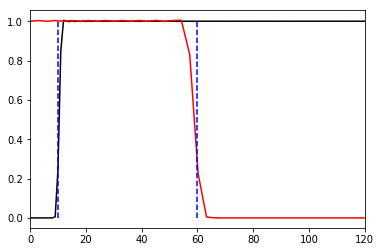

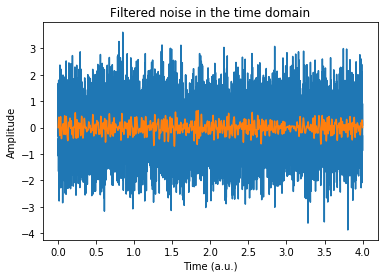

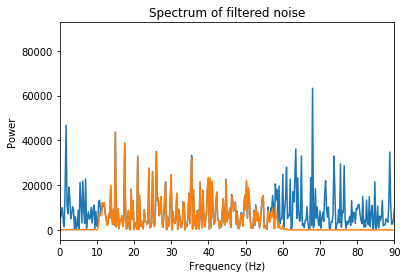

In [7]:
## generate white noise signal
N = samprate*4
noise = np.random.randn(N)
timevec = np.arange(0,len(noise))/samprate


## the better way to filter...


### first apply a high-pass filter
forder = int(10*samprate/lower_bnd)+1
filtkern = signal.firwin(forder,lower_bnd,pass_zero=False,fs=samprate)

# spectrum of kernel
hz = np.linspace(0,samprate/2,int(np.floor(len(filtkern)/2)+1))
filterpow = np.abs(scipy.fftpack.fft(filtkern))**2
plt.plot(hz,filterpow[:len(hz)],'k')

# zero-phase-shift filter with reflection
fnoise = signal.filtfilt(filtkern,1,noise)



### repeat for low-pass filter
forder = 20*int(samprate/upper_bnd)+1
filtkern = signal.firwin(forder,upper_bnd,fs=samprate,pass_zero=True)

# spectrum of kernel
hz = np.linspace(0,samprate/2,int(np.floor(len(filtkern)/2)+1))
filterpow = np.abs(scipy.fftpack.fft(filtkern))**2

plt.plot(hz,filterpow[:len(hz)],'r')
plt.plot([lower_bnd, lower_bnd],[0,1],'b--')
plt.plot([upper_bnd, upper_bnd],[0,1],'b--')
plt.xlim([0,upper_bnd*2])

plt.show()


## now filter the filtered signal
fnoise = signal.filtfilt(filtkern,1,fnoise)


# make some plots
plt.plot(timevec,noise,label='noise')
plt.plot(timevec,fnoise,label='filtered noise')
plt.xlabel('Time (a.u.)')
plt.ylabel('Amplitude')
plt.title('Filtered noise in the time domain')
plt.show()


# plot power spectrum
noiseX  = np.abs(scipy.fftpack.fft(noise))**2
fnoiseX = np.abs(scipy.fftpack.fft(fnoise))**2
hz = np.linspace(0,samprate,len(fnoise))

plt.plot(hz,noiseX,label='Noise')
plt.plot(hz,fnoiseX,label='Filtered noise')
plt.xlim([0,upper_bnd*1.5])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Spectrum of filtered noise')
plt.show()


---
# Quantifying roll-off characteristics
---


In [8]:
## create a windowed sinc filter

# simulation parameters
srate = 1000
time  = np.arange(-4,4,1/srate)
pnts  = len(time)

# FFT parameters
nfft = 10000
hz   = np.linspace(0,srate/2,int(np.floor(nfft/2)+1))

filtcut  = 15
sincfilt = np.sin(2*np.pi*filtcut*time) / time

# adjust NaN and normalize filter to unit-gain
sincfilt[~np.isfinite(sincfilt)] = np.max(sincfilt)
sincfilt = sincfilt/np.sum(sincfilt)

# windowed sinc filter
sincfiltW = sincfilt * signal.windows.hann(pnts)

# spectrum of filter
sincX = 20*np.log10(np.abs(scipy.fftpack.fft(sincfilt,n=nfft))**2)
sincX = sincX[:len(hz)]

/Users/elliottevers/DocumentsTurbulent/virtual_environments/python_3_jupyter/lib/python3.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


In [9]:
## create a Butterworth high-pass filter

# generate filter coefficients (Butterworth)
filtb,filta = signal.butter(5,filtcut/(srate/2),btype='lowpass')

# test impulse response function (IRF)
impulse  = np.zeros(1001)
impulse[500] = 1
fimpulse = signal.filtfilt(filtb,filta,impulse)

# spectrum of filter response
butterX = 20*np.log10(np.abs(scipy.fftpack.fft(fimpulse,nfft))**2)
butterX = butterX[:len(hz)]


/Users/elliottevers/DocumentsTurbulent/virtual_environments/python_3_jupyter/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/elliottevers/DocumentsTurbulent/virtual_environments/python_3_jupyter/lib/python3.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


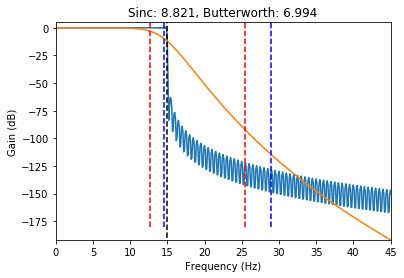

In [10]:
## plot frequency responses

plt.plot(hz,sincX)
plt.plot(hz,butterX)

plotedge = int(np.argmin( (hz-filtcut*3)**2 ))
plt.xlim([0,filtcut*3])
plt.ylim([np.min((butterX[plotedge], sincX[plotedge])), 5])
plt.plot([filtcut,filtcut],[-190, 5],'k--')



# find -3 dB after filter edge
filtcut_idx = np.min( (hz-filtcut)**2 )

sincX3db   = np.argmin( (sincX--3)**2 )
butterX3db = np.argmin( (butterX--3)**2 )

# add to the plot
plt.plot([hz[sincX3db],hz[sincX3db]],[-180,5],'b--')
plt.plot([hz[butterX3db],hz[butterX3db]],[-180,5],'r--')



# find double the frequency
sincXoct   = np.argmin( (hz-hz[sincX3db]*2)**2 )
butterXoct = np.argmin( (hz-hz[butterX3db]*2)**2 )

# add to the plot
plt.plot([hz[sincXoct],hz[sincXoct]],[-180,5],'b--')
plt.plot([hz[butterXoct],hz[butterXoct]],[-180,5],'r--')



# find attenuation from that point to double its frequency
sincXatten   = sincX[sincX3db*2]
butterXatten = butterX[butterX3db*2]

sincXrolloff   = (sincX[sincX3db]-sincX[sincXoct]) / (hz[sincXoct]-hz[sincX3db])
butterXrolloff = (butterX[butterX3db]-butterX[butterXoct]) / (hz[butterXoct]-hz[butterX3db])

# report!
plt.title('Sinc: %.3f, Butterworth: %.3f' %(sincXrolloff,butterXrolloff) )
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain (dB)')
plt.show()


---
# Remove electrical line noise and its harmonics
---


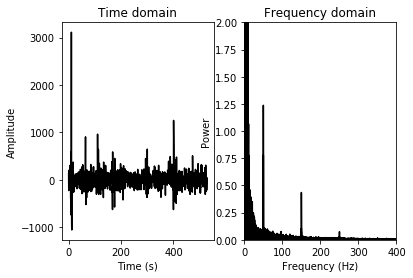

In [12]:
# load data
linedata = sio.loadmat('lineNoiseData.mat')
data  = np.squeeze(linedata['data'])
srate = linedata['srate'][0]

# time vector
pnts = len(data)
time = np.arange(0,pnts)/srate
time = time.T

# compute power spectrum and frequencies vector
pwr = np.abs(scipy.fftpack.fft(data)/pnts)**2
hz  = np.linspace(0,srate,pnts)


### plotting
# time-domain signal
plt.subplot(121)
plt.plot(time[0:-1:1000],data[0:-1:1000],'k')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Time domain')

# plot power spectrum
plt.subplot(122)
plt.plot(hz,pwr,'k')
plt.xlim([0,400])
plt.ylim([0,2])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Frequency domain')
plt.show()

/Users/elliottevers/DocumentsTurbulent/virtual_environments/python_3_jupyter/lib/python3.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


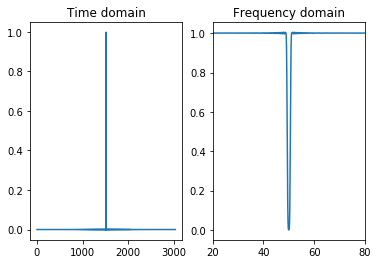

ValueError: The length of the input vector x must be at least padlen, which is 9093.

In [11]:
## narrowband filter to remove line noise

frex2notch = [ 50, 150, 250 ]

# initialize filtered signal
datafilt = data

# loop over frequencies
for fi in range(0,len(frex2notch)):
    
    # create filter kernel using fir1
    frange = [frex2notch[fi]-.5, frex2notch[fi]+.5]
    order  = int( 150*(srate/frange[0]) )
    order  = order + ~order%2
    
    # filter kernel
    filtkern = signal.firwin( order,frange,pass_zero=True,fs=srate )
    
    # visualize the kernel and its spectral response
    plt.subplot(121)
    plt.plot(filtkern)
    plt.title('Time domain')
    
    plt.subplot(122)
    plt.plot(np.linspace(0,srate,10000),np.abs(scipy.fftpack.fft(filtkern,10000))**2)
    plt.xlim([frex2notch[fi]-30, frex2notch[fi]+30])
    plt.title('Frequency domain')
    plt.show()
    
    # recursively apply to data
    datafilt = signal.filtfilt(filtkern,1,datafilt)
    
### plot the signal
plt.subplot(121)
plt.plot(time,data,'k',label='Original')
plt.plot(time,datafilt,'r',label='Notched')
plt.xlabel('Time (s)')
plt.legend()


# compute the power spectrum of the filtered signal
pwrfilt = np.abs(scipy.fftpack.fft(datafilt)/pnts)**2

# plot power spectrum
plt.subplot(122)
plt.plot(hz,pwr,'k',label='Original')
plt.plot(hz,pwrfilt,'r',label='Notched')
plt.xlim([0,400])
plt.ylim([0,2])
plt.title('Frequency domain')
plt.show()


---
# Use filtering to separate birds in a recording
---


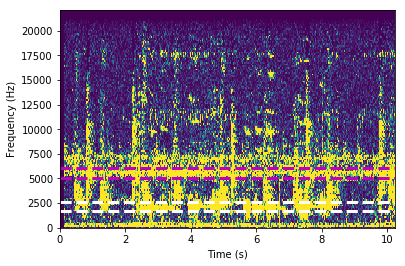

In [13]:
# load in birdcall
fs,bc = scipy.io.wavfile.read('/Users/elliottevers/Documents/git-repos.nosync/dsp/labs/spectral_analysis/XC403881.wav')


# time-frequency analysis via spectrogram (see section on spectral methods)
frex,time,pwr = scipy.signal.spectrogram(bc[:,0],fs)
plt.pcolormesh(time,frex,pwr,vmin=0,vmax=9)
plt.xlabel('Time (s)'), plt.ylabel('Frequency (Hz)')


# frequency ranges
frange = [ [1700, 2600], [5100, 6100] ]

# draw boundary lines on the plot
colorz = 'wm';
for fi in range(0,len(frange)):
    plt.plot([time[0],time[-1]],[frange[fi][0],frange[fi][0]],colorz[fi]+'--',linewidth=3)
    plt.plot([time[0],time[-1]],[frange[fi][1],frange[fi][1]],colorz[fi]+'--',linewidth=3)

plt.show()

In [14]:
## compute and apply FIR filters

# initialize output matrix
filteredSig = np.zeros((2,2,len(bc)))

# loop over filters
for filteri in range(len(frange)):
    
    # design filter kernel
    order    = round( 10*(fs/frange[filteri][0]) )
    order    += ~order%2
    filtkern = signal.firwin(order,frange[filteri],fs=fs,pass_zero=False)
    
    # loop over channels
    for chani in range(2):
        
        # get data from this channel
        dat1chan = bc[:,chani]
        
        # zero-phase-shift filter
        fsig = signal.filtfilt(filtkern,1,dat1chan)
        # enter into the matrix
        filteredSig[filteri,chani,:] = fsig
        

/Users/elliottevers/DocumentsTurbulent/virtual_environments/python_3_jupyter/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/elliottevers/DocumentsTurbulent/virtual_environments/python_3_jupyter/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/elliottevers/DocumentsTurbulent/virtual_environments/python_3_jupyter/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: Fu

In [15]:
## play sounds

from IPython.display import Audio

# # original
# Audio(np.array(bc[:,0]), rate=fs)

# # lower frequency range
# Audio(np.array(filteredSig[0,0,:]), rate=fs)

# higher frequency range
Audio(np.array(filteredSig[1,0,:]), rate=fs)
